## Imports & Constants

In [1]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torchmetrics import Accuracy
from torchmetrics.classification import BinaryAccuracy

import sys
sys.path.append('..')
from src.code_help import plot_predictions, plot_train_test_curves, plot_decision_boundary

In [2]:
MANUAL_SEED = 42
MIN_FEATURES = 4
HIDDEN_FEATURES = 8

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
!nvidia-smi

Fri Oct 25 00:30:37 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.51.01              Driver Version: 565.90         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3080 ...    On  |   00000000:01:00.0  On |                  N/A |
| N/A   58C    P8             16W /  115W |     575MiB /  16384MiB |      5%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
torch.cuda.device_count()

1

## Date Prep

In [5]:
X, y = make_moons(n_samples=1000, random_state=MANUAL_SEED)

X, y = torch.from_numpy(X).type(torch.float), torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=MANUAL_SEED)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([800, 2]),
 torch.Size([200, 2]),
 torch.Size([800]),
 torch.Size([200]))

In [6]:
X_train.dtype, X_test.dtype, y_train.dtype, y_test.dtype

(torch.float32, torch.float32, torch.float32, torch.float32)

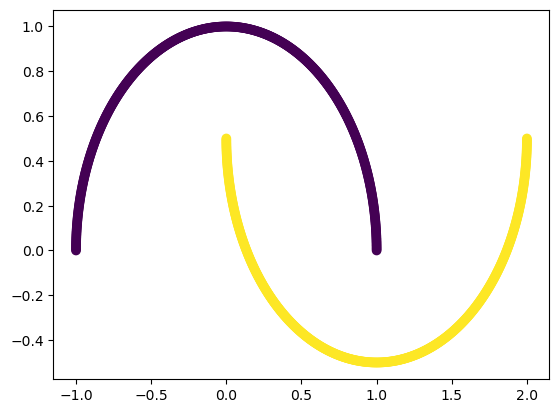

In [7]:
plt.scatter(x=X[:, 0],y=X[:, 1],c=y);

In [8]:
X_train.dtype, X_test.dtype, y_train.dtype, y_test.dtype

(torch.float32, torch.float32, torch.float32, torch.float32)

## Model prep

In [9]:
class nonLinearModel_1(nn.Module):
    def __init__(self, in_features=2, out_features=1, hidden_features=[16, 32, 64, 128]):
        super().__init__()
        self.input_layer = nn.Linear(in_features=in_features, out_features=hidden_features[0])
        self.seq_layer = nn.Sequential(
            nn.Linear(in_features=hidden_features[0], out_features=hidden_features[1]),
            nn.ReLU(),
            nn.Linear(in_features=hidden_features[1], out_features=hidden_features[0]),
            nn.ReLU(),
            nn.Linear(in_features=hidden_features[0], out_features=out_features)
        )
    def forward(self, x):
        return self.seq_layer(self.input_layer(x))

model_1 = nonLinearModel_1().to(device)
# model_1.state_dict(), list(model_1.parameters())

## Loss and Optim Prep

In [10]:
# Binary cross entropy with and without logits
loss_without_logits_fn = nn.BCELoss()
loss_fn = nn.BCEWithLogitsLoss()

# OPtimizer
adam_optim = torch.optim.Adam(params=model_1.parameters(), lr=0.001) # Default LR

# Accuracy
# acc_fn = Accuracy(task="multiclass", num_classes=2).to(device)
acc_fn = BinaryAccuracy().to(device)

def cust_acc_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/ len(y_pred)) * 100
    return acc

acc_fn.device

device(type='cuda', index=0)

## Send data to device

In [11]:
torch.manual_seed(MANUAL_SEED)
torch.cuda.manual_seed(MANUAL_SEED)

X_train, X_test = X_train.to(device), X_test.to(device)
y_train_int, y_train, y_test_int, y_test = y_train.type(torch.LongTensor).to(device), y_train.to(device), y_test.type(torch.LongTensor).to(device), y_test.to(device)

X_train.device, X_test.device, y_train.device, y_test.device

(device(type='cuda', index=0),
 device(type='cuda', index=0),
 device(type='cuda', index=0),
 device(type='cuda', index=0))

In [12]:
y_train_int.device, y_train.device, y_test_int.device, y_test.device

(device(type='cuda', index=0),
 device(type='cuda', index=0),
 device(type='cuda', index=0),
 device(type='cuda', index=0))

In [13]:
y_train_int.dtype, y_train.dtype, y_test_int.dtype, y_test.dtype

(torch.int64, torch.float32, torch.int64, torch.float32)

## Train and Test Loop

In [14]:
torch.manual_seed(MANUAL_SEED)
torch.cuda.manual_seed(MANUAL_SEED)
# What's coming out of our model?
y_logits = model_1(X_train).squeeze()
# logits (raw outputs of model)
print("Logits:", y_logits[:5])
## Your code here ##
y_pred_probs = torch.sigmoid(y_logits)
# Prediction probabilities
print("Pred probs:", y_pred_probs[:5])
## Your code here ##
y_preds = torch.round(y_pred_probs)
# Prediction labels
print("Pred labels:", y_preds[:5])
## Your code here ##

Logits: tensor([-0.0569,  0.0452,  0.0067,  0.0084,  0.0024], device='cuda:0',
       grad_fn=<SliceBackward0>)
Pred probs: tensor([0.4858, 0.5113, 0.5017, 0.5021, 0.5006], device='cuda:0',
       grad_fn=<SliceBackward0>)
Pred labels: tensor([0., 1., 1., 1., 1.], device='cuda:0', grad_fn=<SliceBackward0>)


In [15]:
torch.manual_seed(MANUAL_SEED)
torch.cuda.manual_seed(MANUAL_SEED)

# Setup epochs
epochs = 1000

# Send data to the device
X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)
y_train_int, y_test_int = y_train_int.to(device), y_test_int.to(device)

# Loop through the data
for epoch in range(epochs):
    ### Training
    model_1.train()
    
    # 1. Forward pass (logits output)
    y_logits = model_1(X_train).squeeze()
    # Turn logits into prediction probabilities
    y_pred_probs = torch.sigmoid(y_logits)
    
    # Turn prediction probabilities into prediction labels
    y_preds = torch.round(y_pred_probs)
    
    # 2. Calculaute the loss
    loss = loss_fn(y_logits, y_train) # loss = compare model raw outputs to desired model outputs
    # print(y_train_int.device, y_preds.device)
    # Calculate the accuracy
    acc = acc_fn(y_train_int, y_preds) # the accuracy function needs to compare pred labels (not logits) with actual labels
    
    # 3. Zero the gradients
    adam_optim.zero_grad()
    
    # 4. Loss backward (perform backpropagation) - https://brilliant.org/wiki/backpropagation/#:~:text=Backpropagation%2C%20short%20for%20%22backward%20propagation,to%20the%20neural%20network's%20weights.
    loss.backward()
    # 5. Step the optimizer (gradient descent) - https://towardsdatascience.com/gradient-descent-algorithm-a-deep-dive-cf04e8115f21#:~:text=Gradient%20descent%20(GD)%20is%20an,e.g.%20in%20a%20linear%20regression) 
    adam_optim.step()
    
    ### Testing
    model_1.eval() 
    with torch.inference_mode():
        # 1. Forward pass (to get the logits)
        y_test_logits = model_1(X_test).squeeze()    
        # Turn the test logits into prediction labels
        y_test_pred_probs = torch.sigmoid(y_test_logits)
        y_test_preds = torch.round(y_test_pred_probs)
        # 2. Caculate the test loss/acc
        test_loss = loss_fn(y_test_logits, y_test)
        test_acc = cust_acc_fn(y_test_int, y_test_preds)
    
    # Print out what's happening every 100 epochs
    if epoch % 100 == 0:
        print(f"Epoch:{epoch} : \n Train Loss: {loss:.4f} | Train Accuracy: {acc:.2f} \n Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.2f} ")
    

Epoch:0 : 
 Train Loss: 0.6966 | Train Accuracy: 0.42 
 Test Loss: 0.6918 | Test Accuracy: 62.50 
Epoch:100 : 
 Train Loss: 0.2943 | Train Accuracy: 0.86 
 Test Loss: 0.3045 | Test Accuracy: 87.50 
Epoch:200 : 
 Train Loss: 0.2076 | Train Accuracy: 0.90 
 Test Loss: 0.2159 | Test Accuracy: 90.00 
Epoch:300 : 
 Train Loss: 0.1686 | Train Accuracy: 0.92 
 Test Loss: 0.1802 | Test Accuracy: 90.50 
Epoch:400 : 
 Train Loss: 0.0727 | Train Accuracy: 0.98 
 Test Loss: 0.0747 | Test Accuracy: 98.00 
Epoch:500 : 
 Train Loss: 0.0134 | Train Accuracy: 1.00 
 Test Loss: 0.0127 | Test Accuracy: 100.00 
Epoch:600 : 
 Train Loss: 0.0047 | Train Accuracy: 1.00 
 Test Loss: 0.0044 | Test Accuracy: 100.00 
Epoch:700 : 
 Train Loss: 0.0025 | Train Accuracy: 1.00 
 Test Loss: 0.0023 | Test Accuracy: 100.00 
Epoch:800 : 
 Train Loss: 0.0016 | Train Accuracy: 1.00 
 Test Loss: 0.0015 | Test Accuracy: 100.00 
Epoch:900 : 
 Train Loss: 0.0011 | Train Accuracy: 1.00 
 Test Loss: 0.0010 | Test Accuracy: 100.0

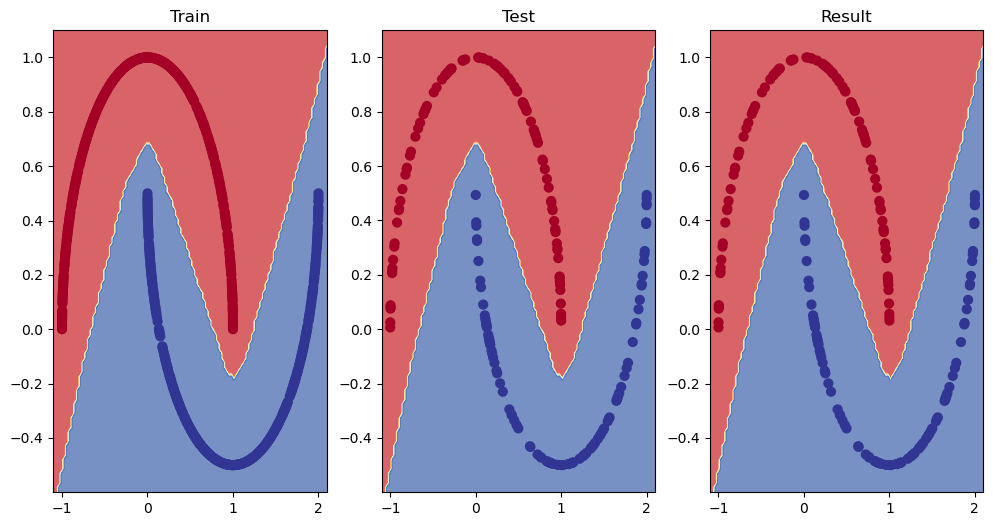

In [17]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 3, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)
plt.subplot(1, 3, 3)
plt.title("Result")
plot_decision_boundary(model_1, X_test, y_test_preds)